# Demo of Universal Sequence Maps (USM) in Python
**How to generate USM using the pyusm library**
By Katherine Wuestney

**Contents**

* [Introduction](#Intro)  
    - [Terminology Introduction](#termintro)
* [Section 1](#Section1) Background of USM, their history and theory.
    - [Section 1.1](#Section1.1) Iterated Function Systems and the Chaos Game
    - [Section 1.2](#Section1.2) Chaos Game Representation (CGR) for studying patterns in sequences
        - [Example 1.2.1](#Example1.2.1)
        - [Example 1.2.2](#Example1.2.2)
    - [Section 1.3](#Section1.3) Generalizing CGR using USM - properties and applications
* [Section 2](#Section2) Demo of usm module
    - [Section 2.1](#Section2.1) USM.make_usm()
        - [Figure 2.1.1](#Figure2.1.1)
        - [Figure 2.1.2](#Figure2.1.2)
        - [Figure 2.1.3](#Figure2.1.3)
        - [Example 2.1.1](#Example2.1.1)

<a id='Intro'></a>
## Introduction
Universal sequence mapping is a process of mapping a sequence with discrete state space (e.g. DNA, written language) to real-valued state space in $\mathbf{R}^d$ allowing for greater variety and opportunity to apply multivariate statistical methods. The following notebook introduces the conceptual background of USM and demonstrates python implementations of the universal sequence mapping tools created by S. Vinga and J. Almeida and referenced in [1](#1) [2](#2) [3](#3). Original javascript and matlab toolkit on which parts of pyusm is derived can be found at the github repository [usm.github.com](https://github.com/usm/usm.github.com.git). These implementations follow closely the algorithms used by the original authors but makes some key changes in order for the tools to be more generalizable and more pythonic. Where applicable, mathematical proofs are included to support changes to formulas. 

<a id='termintro'></a>
### Terminology Introduction - Use this section as a glossary
The topics presented in this notebook are highly cross-disciplinary and as such there are a variety of different terms used in the literature to refer to the same basic concepts. To ensure clarity of discussion we will define the following within the context of symbolic sequence analysis:
* **Symbol** - a nominal data element which has no numeric magnitude in the general Euclidean sense. Symbols are common data types encountered in linguistics and natural language processing, information theory and cryptography as well as genomics. A symbol is congruous with a single category of a categorical variable. A symbol can be anything, including numbers, but it does not behave like regular numbers do as it is generally a proxy "symbolizing" some other construct.

* **Sequence** or **Symbolic sequence** - a set of indexed symbols for which the order of the symbols is integral and thus object of analysis. Sequences are commonly encountered in genomics, time series analysis, linguistics and natural language processing, among others. Synonyms of sequence include strings, series, or sometimes vectors. 

* **Generating function** - a process or phenomenon which produces or is represented by a sequence of symbols.

* **Alphabet** - the set of all possible symbols a generating function may produce. For example, if our sequence is a paragraph of a Charles Dickens novel, our generating function could be considered 19th century English typography, and our alphabet would be the 26 letters of the English alphabet plus each punctuation character and special character in use during that time. The term alphabet is congruous to the term "state space" from dynamical systems, in that the alphabet functions as the basic state space of a symbolic generating function. There are many different ways the size of an alphabet is refered to in the literature but for this discussion here we will refer to an alphabet's size as its dimension *d*.

* **k-gram** - a subsequence of a longer sequence comprising of k sequential symbols. For example, if our sequence is "ACTGGCA", "TG" would be a k-gram with k=2. In symbolic sequence analysis we are often most interested in the frequency and patterns of k-grams of various lengths. Synonyms for k-gram include L-tuple, subsequence, words, motifs, sub-strings, or vectors. 

* **Suffix** - the k-gram occurring at the very end of a sequence. For "ACTGGCA", its length 3 suffix is the k-gram "GCA".

* **Prefix** - the k-gram occurring at the very beginning of a sequence.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import patches, collections
from IPython.display import HTML
from pathlib import Path
import pyusm

In [3]:
demo_files = Path.cwd() / "demo_files"
#demo_files

<a id='Section1'></a>
# Section 1 History and Theory of USM

<a id='Section1.1'></a>
### 1.1 - Iterated Function Systems and the Chaos Game

The story of the development of universal sequence mapping begins with discoveries made in the field of iterated functions and the mathematical theory of fractals. In particular, the basic idea behind universal sequence mapping is rooted in an interesting method for generating fractal objects using iterated function systems introduced by Barnsley [4](#4). He called this method the Chaos Game, and it is "played" as follows:  

    1. Pick three points on a coordinate plane such that they are not all in one line and label them a, b, and c. We'll call these points the vertices. 

The Chaos Game algorithm and its variations, which Barnsely also calls the Deterministic Algorithm and the Random Iteration Algorithm, are introduced in pages 86-92 in [4](#4).

In [ ]:
#coordinate values of the vertices
x_vals = np.array([-1, 0, 1])
y_vals = np.array([0, 1, 0])
# set up figure to hold our coordinate plane
xmin = x_vals.min() - 0.2
xmax = x_vals.max() + 0.2
ymin = y_vals.min() - 0.2
ymax = y_vals.max() + 0.2
fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
#plot and label the vertices
ax.scatter(x_vals, y_vals, c='b', label='vertices')
for i, xy in enumerate(zip(x_vals, y_vals)):
    labels = ['a', 'b', 'c']
    ax.annotate(f'{labels[i]}', xy, xycoords='data', xytext=(5, 5), textcoords='offset pixels')
ax.legend()
plt.show()

    2. Pick another point somewhere on the plane to be the starting point.

In [ ]:
#set starting coordinate
start = np.array([0.0, 0.25])
ax.scatter(x=0.0, y=0.25, s=3, c='r', label='inital point')
ax.legend()
fig

    3. Roll a 6-sided die. Mark the next point as halfway between the starting point and the vertex associated with the number on the die:
        - If 1 or 2 -> vertex a
        - If 3 or 4 -> vertex b
        - If 5 or 6 -> vertex c

In [ ]:
vertcoords = {1 : np.array([-1.0, 0.0]), 2 : np.array([-1.0, 0.0]), 3 : np.array([0.0, 1.0]), 4 : np.array([0.0, 1.0]),
             5 : np.array([1.0, 0.0]), 6 : np.array([1.0, 0.0])}
#a = np.array([-1.0, 0.0])
#b = np.array([0.0, 1.0])
#c = np.array([1.0, 0.0])
coords = [start]
#list of first 10 die rolls
rolls = [5, 3, 6, 1, 1, 2, 5, 3, 4, 3]
# first die roll is 5
nextvert = vertcoords[rolls[0]]
#get midpoint between start point and vertex c
nextpoint = (start + nextvert)/2
#nextpoint is [0.5  , 0.125]
coords.append(nextpoint)
ax.scatter(x=nextpoint[0], y=nextpoint[1], s=2, c='g')
ax.annotate('next point', tuple(nextpoint), xytext=(20,20), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
fig

    4. Roll the die again and mark the next point as halfway between the previous point and the vertex associated with the die roll.

In [ ]:
#animation of next 9 die rolls

def init_frame():
    global ax
    ax.cla()
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    ax.scatter(x=0, y=0.25, s=2, c='r', label='inital point')
    ax.scatter(x_vals, y_vals, c='b', label='vertices')
    ax.scatter(x=0.5, y=0.125, s=2, c='g')
    ax.legend()
    for i, xy in enumerate(zip(x_vals, y_vals)):
        labels = ['a', 'b', 'c']
        ax.annotate(f'{labels[i]}', xy, xycoords='data', xytext=(5, 5), textcoords='offset pixels')
        
def animation(i):
    nextvt = vertcoords[rolls[i]]
    nextpt = (coords[-1] + nextvt)/2
    coords.append(nextpt)
    x, y = nextpt
    ax.scatter(x, y, s=2, c='g')
    
tenrolls = FuncAnimation(fig, animation, frames=range(1, 10), init_func=init_frame, interval=1000, repeat=True, blit=False)
HTML(tenrolls.to_jshtml())

*Click the <i class="fa fa-play"></i> button to start plot animation*

    5. Continue step 4 over a few hundred to a few thousand iterations and observe the pattern that arises. 

In [ ]:
with open(demo_files/'chaosgame3v_fast.html', 'r') as fhand:
    cgfast = fhand.read()
HTML(cgfast)

The figure that emerges is none other than the fractal known as the Sierpinski triangle.

The Chaos Game can be played with any arbitrary number of vertices. Of note is when the vertices are a multiple of 4. In this case of 4 vertices, the pattern is a uniformly filled square and for greater multiples of 4 such as 8 or 16, the pattern is a uniformly filled polygon surrounding an empty center.

Here is the Chaos Game with 8 vertices:  

> ![8 Vertex Chaos Game](demo_files/chaosgame8v.png)

and 16 vertices:  

>![16 Vertex Chaos Game](demo_files/chaosgame16v.png)

And here is the Chaos Game with 4 vertices:  

>![4 Vertex Chaos Game](demo_files/chaosgame4v.png)

<a id='Section1.2'></a>
### 1.2 Chaos Game Representation  

In 1990, inspired by an observation that the 4, 8, and 16 vertex chaos game figures would display elaborate patterns depending on the quality of the pseudorandom number generator, Jeffrey [5](#5) proposed feeding the chaos game with natural sequences, such as DNA, instead of random ones, as a way to reveal underlying structures in the sequences. He called this new sequence visualization method Chaos Game Representation (CGR) and it works by assigning each unique symbol in the sequence to a vertex and using the sequence to dictate how the CGR points are plotted. 

<a id='Example1.2.1'></a>
#### Example 1.2.1 CGR of the Human Beta Globin Region  

>We can demonstrate the construction of a CGR of a DNA sequence using the Human Beta Globin region of Chromosome 11 (sequence publicly availabe from [Genbank](https://www.ncbi.nlm.nih.gov/nuccore/U01317.1)). DNA has 4 nucleotide bases (A, C, G, and T), which we assign to the four vertices (0, 0), (0, 1), (1, 1), and (1, 0) respectively and set our initial point as the centroid of the vertices. The first 6 bases of HUMHBB are G, A, A, T, T, and C [6](#6). So the second CGR coordinate is computed as the midpoint between the centroid and the coordinate (1, 1) which is the vertex associated with nucleotide base G. The third CGR coordinate is the midpoint between the second coordinate and (0, 0), the vertex associated with base A, and so on. The CGR plot of all 73,308 bases then looks like this:

In [4]:
with open(demo_files/'humhbb.txt', 'r') as fhand:
    seq = list(fhand.read())
A = {'A':(0, 0), 'C':(0, 1), 'G':(1, 1), 'T':(1, 0)}
hbbcgr = pyusm.USM.cgr2d(seq, A=A)

In [14]:
hbbcgr.coord_dict.items()

dict_items([('A', (0, 0)), ('C', (0, 1)), ('G', (1, 1)), ('T', (1, 0))])

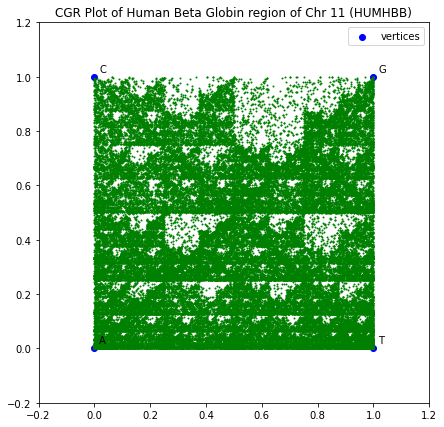

In [10]:
#get coordinate values of the vertices
labels, verts = zip(*hbbcgr.coord_dict.items())
x_vals, y_vals = zip(*verts)
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
# set up figure to hold our cgr
xmin = x_vals.min() - 0.2
xmax = x_vals.max() + 0.2
ymin = y_vals.min() - 0.2
ymax = y_vals.max() + 0.2

cgr, ax1 = plt.subplots(figsize=(7, 7))
ax1.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

#plot and label the vertices
ax1.scatter(x_vals, y_vals, c='b', label='vertices')
plt.title("CGR Plot of Human Beta Globin region of Chr 11 (HUMHBB)")
for i, xy in enumerate(zip(x_vals, y_vals)):
    ax1.annotate(f'{labels[i]}', xy, xycoords='data', xytext=(5, 5), textcoords='offset pixels')
ax1.legend()
x_coords, y_coords = zip(*hbbcgr.fw)
ax1.scatter(x_coords, y_coords, s=1, c='g')

The distinctive "double-scoop" pattern above was found to be common among vertebrate genetic sequences. 

Since Jeffrey's seminal paper, many researchers have studied the properties and applications of CGR to the study of symbolic sequences. Some of the key properties discovered are:
1. Where the side lengths of the space containing the full CGR are normalized to 1, two sequences of any length which share suffixes of length k (i.e. the last k symbols are the same) will be contained within a subquadrant of the CGR space with sides of length 2<sup>-k</sup>. This point can be illustrated as follows:

<a id='Example1.2.2'></a>
#### Example 1.2.2 

> The code below defines two sequences of different lengths, 'a' and 'b', but each ends in the same 3 symbols: 'GGA'.

In [8]:
a = list('CCCAGCTACTCAGGAGGCCGAAATGGGAGGATCCCTTGAGCTCAGGAGGA')
b = list('GCAGAGTCCAGGGTCCGAGAAGGGGA')
print(f"Sequence 'a' contains {len(a)} symbols")
print(f"Sequence 'b' contains {len(b)} symbols")

Sequence 'a' contains 50 symbols
Sequence 'b' contains 26 symbols


> Here are what CGRs of each sequence looks like.

In [ ]:
#generate 2d cgr instances for each seq
cgr_a = pyusm.USM.cgr2d(a, A=A)
cgr_b = pyusm.USM.cgr2d(b, A=A)
cgr2, ax2 = plt.subplots(figsize=(6, 6))
ax2.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax2.scatter(x_vals, y_vals, c='b', label='vertices')
for i, xy in enumerate(zip(x_vals, y_vals)):
    ax2.annotate(f'{labels[i]}', xy, xycoords='data', xytext=(5, 5), textcoords='offset pixels')
ax2.legend()
xa, ya = zip(*cgr_a.fw)
xb, yb = zip(*cgr_b.fw)
ax2.scatter(xa, ya, s=5, c='g', label='a')
ax2.scatter(xb, yb, s=5, c='r', label='b')
ax2.annotate('last a', cgr_a.fw[-1], xytext=(-20,30), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
ax2.annotate('last b', cgr_b.fw[-1], xytext=(20,20), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
plt.title("CGR Plot of Sequence 'a' and 'b'")
# set suffix length to calculate subquadrant size
k=3
q = 2**(-k)
qx = np.linspace(0, 1, (2**k)+1)
plt.xticks(qx)
plt.yticks(qx)
ax2.grid()
ax2.set_axisbelow(True)
quad3 = patches.Rectangle((0.375, 0.375), q, q, linewidth='3', edgecolor='m', facecolor='none', label='')
quad1 = patches.Rectangle((0, 0), 2**-1, 2**-1, linewidth='3', edgecolor='k', facecolor='none')
quad2 = patches.Rectangle((0.25, 0.25), 2**-2, 2**-2, linewidth='3', edgecolor='k', facecolor='none')
ax2.add_patch(quad1)
ax2.add_patch(quad2)
ax2.add_patch(quad3)

> Notice the same subquadrant, highlighted in pink, contains the CGR coordinate of the last symbol of both 'a' and 'b'. The side of the subquadrant is length $2^{-3} = 0.125$ which is in line with the length of the suffix shared by 'a' and 'b', which is 3 symbols long.  
   
> In fact, every coordinate plotted in this subquadrant corresponds to a sequence/subsequence with the suffix 'GGA'. And every subquadrant of this size contains coordinates which share suffixes of length 3. The smaller the subquadrant the longer the suffix will be that all coordinates in that subquadrant share. Which leads to the next few properties of CGRs. 

2. Euclidean distance between any two points does not indicate nearness within the parent sequence but rather the length of a shared suffix. 
3. The CGR map functions as a generalization of a Markov Chain Transition Matrix [8](#8), since the density of coordinates in any region of the map corresponds with the frequency of the k-gram associated with that region. This property was proven by Almeida et al. in [8](#8) and they showed that in fact a Markov Chain transition matrix is a special case of the CGR.
4. The CGR map depicts all k-gram frequencies, for all k > 0, simultaneously.
5. A perfectly random sequence will fill the CGR space evenly [1](#1).
6. For any k-gram missing in the sequence, the subquadrant for that k-gram will be empty [1](#1). 

<a id='Section1.3'></a>
### 1.3 USM - properties and applications
Almeida and Vinga expanded on the original 4 vertex CGR, which was only useful to symbol spaces with 4 symbol alphabets, to alphabet spaces of arbitrary size by defining the vertices of map as the vertices of a unit hypercube. Therefore in the case of DNA as in the examples above, instead of assigning the four nucleotides to the vertices {'A':(0, 0), 'C':(0, 1), 'G':(1, 1), 'T':(1, 0)} we would assign them to the vertices {'A':(1, 0, 0, 0), 'C':(0, 1, 0, 0), 'G':(0, 0, 1, 0), 'T':(0, 0, 0, 1)}. Almeida and Vinga call this new approach Universal Sequence Mapping or USM [2](#2). 

This approach ensures that the USM projection is always bijective no matter the alphabet size such that "each [0, 1]<sup>n</sup> coordinate corresponds to a unique sequence and each sequence corresponds to a unique[0, 1]<sup>n</sup> coordinate" [9](#9). This means that, theoretically, a single USM coordinate contains information of the entire sequence and the entire sequence could be recovered from a single coordinate. In practice, the maximum sequence length recoverable from a single USM coordinate is limited only by the bit precision of the software performing the computation [9](#9).  

From hereforth we will use the following notation conventions in regard to a *d*-dimensional USM object:
* For symbolic sequence *X*, *N* is the length of the sequence, *S* is the [alphabet](#termintro) of the sequence, and the cardinality of *S*, *d*, is the number of unique symbols in *X*.
* *d* defines the dimension of the USM object generated from *X*
* Each symbol in *X* has a corresponding USM coordinate, represented as the set $\left\{x_i \in \mathbf{R}^d, (i = 1, \dots, N)\right\}$
* The vertices of the USM coordinate space is given by 
$$
y_i = \left\{
        \begin{array}\\
            (1, 0, 0, \dots, 0) & \mbox{if } \ X_i = S_1 \\
            (0, 1, 0, \dots, 0) & \mbox{if } \ X_i = S_2 \\
            (0, 0, 1, \dots, 0) & \mbox{if } \ X_i = S_3 \\
            \vdots \ \ \ & \\
            (0, 0, 0, \dots, 1) & \mbox{if } \ X_i = S_d \\
        \end{array}
     \right. 
$$ 
    where the coordinates of each vertex are equivalent to the rows of the *dxd* identity matrix.  
    
* The equation for computing $x_i$ is given by  
$$
 x_i = x_{i-1} + \frac{1}{2}(y_i - x_{i-1}), \ \ \ i = 1, \dots , N
$$  


Universal sequence mapping is a process of mapping a sequence with discrete state space (e.g. DNA, written language) to real-valued state space in $\mathbf{R}^d$ allowing for greater variety and opportunity to apply multivariate statistical methods.

<a id='Section2'></a>
# Section 2 Demo of usm module

The module usm.py contains functions to compute the coordinates of CGRs and USMs based on the algorithms created by Vinga and Almeida. The module defines the USM class (a core class of the pyusm library) which contains two classmethods for initiating a USM/CGR mapping from a sequence: (1) make_usm() which translates and expands the original Matlab code provided by Vinga and Almeida for [1](#1) and (2) cgr2d() which is an implementation of the 2d CGR formula proposed by Almeida and Vinga in [3](#3).  

The structure of the code in usm.py has been altered to be more flexible and pythonic but it still follows the same basic process for calculating the coordinates from a symbolic sequence as the original Matlab code found in usm_make.m [usm.github.com](https://github.com/usm/usm.github.com.git). Both USM.make_usm() and USM.cgr2d() return an object of the class USM() which has attributes to store coordinates calculated forward through the sequence as well as backward through the sequence, and a dictionary of each vertex coordinate and its corresponding symbol. The attribute USM.form tells how the object was generated, either "USM" or "CGR" depending on which method was used.  

For this demonstration we will only focus on USM.make_usm().

<a id='Section2.1'></a>
### 2.1 USM.make_usm()
> USM.make_usm(sequence, A=None, seed='centroid', deep_copy=True)  

The classmethod USM.make_usm() takes a symbolic sequence as input, in the format of a string or 1-d array-like object and outputs a USM object containing the forward and backward map coordinate arrays and a dict mapping the symbols of the sequence alphabet to the vertex coordinates. The basic USM.make_usm() algorithm is mapped out in [Figure 2.1.1](#Figure2.1.1) and summarised below:
1. Uses np.unique(seq, return_inverse=True) to get 'uu' a list of each unique symbol in the sequence and 'J' a list containing the sequence coded with the index values of the symbol in the unique symbol list.
2. Defines 'Y', a pxp identity matrix where p is the length of the unique symbol list.
3. Stores a dictionary mapping each symbol in the alphabet to its vertex coordinate in the variable 'coord_dict'.
3. Defines 'X' by slicing 'Y' with 'J'. 'X' is essentially a transformed copy of the input sequence where each symbol is replaced with the row vector of the identity matrix defining that symbols vertex coordinate. 
4. Set the first element of the coordinates list, 'f' to the seed based on the method defined by the kwarg 'seed'.
5. For i in range(len(seq)):
    Calculate the next coordinate, 'u', by the following equation: $u=0.5*f[i]+0.5*X[i]$  
    The $X[i]$ is the coordinate of the vertex corresponding the symbol in the input sequence at index i.
    Append 'u' to the list 'f' and continue.
6. The same basic process is also used to calculate backwards USM coordinates by starting with the last element in X and iterating X in reverse.
7. Create instance of a USM() class with 'f' stored as the attribute USM.fw, 'b' stored as USM.bw, and 'coord_dict' as USM.coord_dict.
8. Return the instance of the CGR class containing the USM coordinates and vertex dict.

Steps 1-3 are performed by the helper function get_alphabet_coords() [Figure 2.1.2](#Figure2.1.2).  
Steps 4-5 are depicted visually in [Figure 2.1.3](#Figure2.1.3).  

[Example 2.1.1](#Example2.1.1) demonstrates the use of USM.make_usm() to create a USM map of a short DNA sequence.

__Optional Kwargs__  

The make_usm() method allows for a few user defined options. The kwarg **'A'** allows the user to supply the function with a predefined vertex dictionary or list of the unique symbols making up the Alphabet of the generating function of **'seq'**. This allows USM vertex coordinates to remain invariant even in the case where one of the symbols in the Alphabet is absent in the sequence.  
  
Additionally, there are three different seeding strategies allowed which are defined by the kwarg **'seed'**.  
- *'centroid'* sets the seed as the center point of the unit hypercube
- *'rand'* sets the seed as a random coordinate within the unit hypercube
- *'circular'* sets the seed following the circular seeding method described by Almeida and Vinga in [10](#10). This method involves first computing the USM coordinates forwards, using the penultimate forward coordinate to seed the computation of backwards USM coordinates and then computing forwards USM coordinates again using the penultimate backwards coordinate as the seed.

<a id="Figure2.1.1"></a>
#### Figure 2.1.1 USM.make_usm
![make_usm.png](demo_files/make_usm.png)

<a id="Figure2.1.2"></a>
#### Figure 2.1.2 get_alphabet_coords
![getalphabetcoords_annotated.png](demo_files/getalphabetcoords_annotated.png)

<a id="Figure2.1.3"></a>
#### Figure 2.1.3 map coordinate calculation subroutine
![make_usm_mapcoord_calc.png](demo_files/make_usm_mapcoord_calc.png)

<a id="Example2.1.1"></a>
#### Example 2.1.1
> Here are the USM coordinates for sequence 'a' from [Example 1.2.2](#Example1.2.2).

In [ ]:
a = list('CCCAGCTACTCAGGAGGCCGAAATGGGAGGATCCCTTGAGCTCAGGAGGA')
USMa = pyusm.USM.make_usm(a, A=list('ACGT'), seed='centroid')
forward_array = np.array(USMa.fw)
print(np.array_str(forward_array, precision=4))

## References
<a id='1'></a>
<div class="csl-entry">[1] Vinga, S., &#38; Almeida, J. S. (2004). Rényi continuous entropy of DNA sequences. <i>Journal of Theoretical Biology</i>, <i>231</i>(3), 377–388. https://doi.org/10.1016/j.jtbi.2004.06.030</div>
<a id='2'></a>
<div class="csl-entry">[2] Almeida, J. S., &#38; Vinga, S. (2002). Universal sequence map (USM) of arbitrary discrete sequences. <i>BMC Bioinformatics</i>, <i>3</i>. https://doi.org/10.1186/1471-2105-3-6</div>
<a id='3'></a>
<div class="csl-entry">[3] Almeida, J. S., &#38; Vinga, S. (2009). Biological sequences as pictures: A generic two dimensional solution for iterated maps. <i>BMC Bioinformatics</i>, <i>10</i>(100), 1–7. https://doi.org/10.1186/1471-2105-10-100</div>
<a id='4'></a>
<div class="csl-entry">[4] Barnsley, M. F. (1988). <i>Fractals everywhere</i>. Academic Press.</div>
<a id='5'></a>
<div class="csl-entry">[5] Jeffrey, H. J. (1990). Chaos game representation of gene structure. <i>Nucleic Acids Research</i>, <i>18</i>(8), 2163–2170. https://doi.org/10.1093/nar/18.8.2163</div>
<a id='6'></a>
<div> [6] Nucleotide [Internet]. Bethesda (MD): National Library of Medicine (US), National Center for Biotechnology Information; [1988] –. Accession No. U01317.1, Homo sapiens Human beta globin region on chromosome 11; [cited 2022 May 05]. Available from: https://www.ncbi.nlm.nih.gov/nuccore/U01317.1</div>
<a id='7'></a>
</div><div class="csl-entry">[7] Almeida, J. S., Carrico, J. A., Maretzek, A., Noble, P. A., &#38; Fletcher, M. (2001). Analysis of genomic sequences by Chaos Game Representation. <i>Bioinformatics</i>, <i>17</i>(5), 429–437.</div>
<a id='8'></a>
<div class="csl-entry">[8] Almeida, J. S., Carrico, J. A., Maretzek, A., Noble, P. A., &#38; Fletcher, M. (2001). Analysis of genomic sequences by Chaos Game Representation. <i>Bioinformatics</i>, <i>17</i>(5), 429–437.</div>
<a id='9'></a>
<div class="csl-entry">[9] Almeida, J. S., Grüneberg, A., Maass, W., &#38; Vinga, S. (2012). Fractal MapReduce decomposition of sequence alignment. <i>Algorithms for Molecular Biology</i>, <i>7</i>(1), 12. https://doi.org/10.1186/1748-7188-7-12</div>
<a id='10'></a>
<div class="csl-entry">[10] Almeida, J. S., &#38; Vinga, S. (2006). Computing distribution of scale independent motifs in biological sequences. <i>Algorithms for Molecular Biology</i>, <i>1</i>(1), 1-11. https://almob.biomedcentral.com/articles/10.1186/1748-7188-1-18</div>